## Import Library

In [1]:
from __future__ import print_function, division
from builtins import range
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

## Configuration

In [2]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 2

## Loading Pretrained Model 

In [3]:
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('glove.6b/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [4]:
#Loading Data and preprocessing
train = pd.read_csv("Datasets from Kaggle (toxic)/train.csv")

#Remove unncessary Columns
#train.drop(columns = ['Unnamed: 0','dataset','comment_text'],inplace=True)

In [5]:
#Look at Dataframe

train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
#Compute total Toxic Score
train['severe_toxic'] = train.severe_toxic * 2 #sever toxic is double of toxic 
train['toxic_score'] = (train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)).astype(int)
train['toxic_score'] = train['toxic_score']/train['toxic_score'].max()
train = train[['comment_text', 'toxic_score']].rename(columns={'comment_text': 'text'}) #new train dataframe

In [7]:
train.tail()

,text,toxic_score
159566,""":::::And for the second time of asking, when ...",0.0
159567,You should be ashamed of yourself \n\nThat is ...,0.0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0.0
159569,And it looks like it was actually you who put ...,0.0
159570,"""\nAnd ... I really don't think you understand...",0.0


In [8]:
#Clean up data

# Text preprocessing steps - remove numbers, capital letters, punctuation, '\n'
import re
import string

# remove all numbers with letters attached to them
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)

# '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
# .lower() - convert all strings to lowercase 
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# Remove all '\n' in the string and replace it with a space
remove_n = lambda x: re.sub("\n", " ", x)

# Remove all non-ascii characters 
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)

# Apply all the lambda functions wrote previously through .map on the comments column
train['text'] = train['text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

In [9]:
# prepare text samples and their labels
print('Loading in comments...')

sentences = train["text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic_score"]
targets = train[possible_labels].values

Loading in comments...


## Convert Sentences (Strings) into Integers

In [10]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
# print("sequences:", sequences); exit()


print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))

max sequence length: 1400
min sequence length: 0
median sequence length: 35
max word index: 19999


In [11]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

# exit()

# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Found 165627 unique tokens.
Shape of data tensor: (159571, 100)


In [12]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


## Load pre-trained word embeddings into an Embedding layer

In [13]:
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

## Train 1D CNN

In [14]:
print('Building model...')

input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Building model...
Training model...
Epoch 1/2
998/998 [==============================] - 39s 38ms/step - loss: 0.0999 - accuracy: 0.8972 - val_loss: 0.0923 - val_accuracy: 0.8990
Epoch 2/2
998/998 [==============================] - 37s 38ms/step - loss: 0.0872 - accuracy: 0.8983 - val_loss: 0.0864 - val_accuracy: 0.8990


## Plotting Data

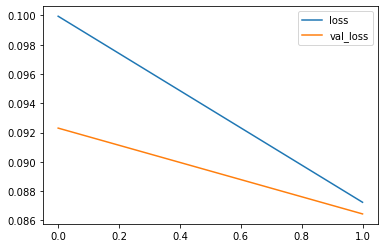

In [15]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

## Accuracy

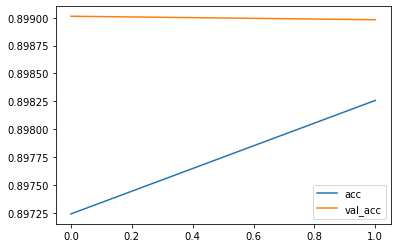

In [16]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

## Validation Data processing

In [22]:
import pandas as pd

validation = pd.read_csv('validation_data.csv')

In [23]:
#Clean up data

# Text preprocessing steps - remove numbers, capital letters, punctuation, '\n'
import re
import string

# remove all numbers with letters attached to them
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)

# '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
# .lower() - convert all strings to lowercase 
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# Remove all '\n' in the string and replace it with a space
remove_n = lambda x: re.sub("\n", " ", x)

# Remove all non-ascii characters 
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)

In [24]:
validation

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"
...,...,...,...
30103,461,I'm sorry. I'm not an admin. I will give you t...,get out my large penis
30104,527,I'm sorry. I'm not an admin. I will give you t...,get out my large penis
30105,352,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook
30106,311,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook


In [25]:
# Apply all the lambda functions wrote previously through .map on the comments column
validation['less_toxic'] = validation['less_toxic'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

validation['more_toxic'] = validation['more_toxic'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)


In [26]:
validation.head()

,worker,less_toxic,more_toxic
0,313,this article sucks woo woo wooooooo,what ...
1,188,and yes people should recognize that but the...,daphne guinness top of the mornin my favou...
2,82,western media yup because every crime in t...,atom you don t believe actual photos of mastu...
3,347,and you removed it you numbskull i don t car...,you seem to have sand in your vagina might w...
4,539,smelly vagina bluerasberry why don t you be...,hey way to support nazis you racist


## Validation Data Scoring with Trained Model

In [27]:
less_toxic_sequences = tokenizer.texts_to_sequences(validation['less_toxic'])
less_toxic_data = pad_sequences(less_toxic_sequences, maxlen=MAX_SEQUENCE_LENGTH)

more_toxic_sequences = tokenizer.texts_to_sequences(validation['more_toxic'])
more_toxic_data = pad_sequences(more_toxic_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [28]:
validation['less_toxic_score'] = model.predict(less_toxic_data).flatten()
validation['more_toxic_score'] = model.predict(more_toxic_data).flatten()

In [29]:
validation.sample(10)

,worker,less_toxic,more_toxic,less_toxic_score,more_toxic_score
26943,303,grafitti defacement i reedited the pa...,your a bitch hey bitch i own this shit bi...,0.007822,0.615054
29862,48,wiki edit i only corrected it what s the pr...,why why do you get soo offended when i call y...,0.005881,0.055547
3624,204,we are going to make sure you are exposed dr...,why you your a son of a b,0.086482,0.136988
20116,699,hey sarekyou just jumped through this burning ...,loser unlike lazy academic know nothing geek p...,0.129394,0.006514
12325,662,blocked your recent behaviour has been utte...,filth shave your beard cut your hair dirt...,0.030110,0.409250
6587,370,i reported this ip at aiv for trolling my and ...,obviously knows more about the band than m...,0.000796,0.005191
20484,416,you have messages on talk rape during the occu...,stop being such a goddamn prick the article w...,0.032219,0.258723
17826,670,kosovo it is very clear that republic of ko...,buffalo bill how do i report user buffalo bill...,0.006601,0.000075
10000,245,objection to vandalism you e mailed me a...,take your template bla bla and stick bal b...,0.018888,0.040794
18680,626,do me a favour do you really think you re the...,you checked his edits you and dar book are t...,0.034461,0.015574


In [30]:
def function(x):
    if x.less_toxic_score < x.more_toxic_score:
        return 1
    else:
        return 0
    
validation["comparison"] = validation[["less_toxic_score", "more_toxic_score"]].apply(function, axis=1)

In [31]:
validation.comparison.value_counts(normalize=1)

1    0.662482
0    0.337518
Name: comparison, dtype: float64